## Bayesian analysis of the steady heat diffusion equation ##

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from heat_diffusion import *
import sampler as mcmc
import seaborn as sns
import scipy
from scipy.stats import multivariate_normal

## Check the versions of each module ##
print('numpy version: ',np.__version__)
print('matplotlib version: ',matplotlib.__version__)
print('seaborn version: ',sns.__version__)
print('scipy version: ',scipy.__version__)

numpy version:  1.22.2
matplotlib version:  3.5.1
seaborn version:  0.11.2
scipy version:  1.8.0


We are going to study how to learn the thermal diffusivity coefficient $k$ that appears in the steady heat diffusion equation $k \dfrac{\partial^{2}T}{\partial x^{2}} + Q = 0$ from noisy data.

First, we are going to just see how the solution to the heat diffusion equation $T(x)$ changes with the thermal diffusivity coefficient to get a sense of the family of solutions we are going to be playing with. To keep it numerically simple, the temperature and distance are normalized and range between 0 and 1.


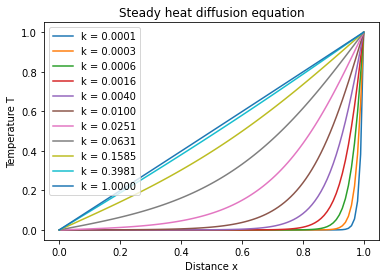

In [3]:
#Plot the solution
#Define parameters
L = 1.0  # length of the rod
N = 101  # number of grid points
dx = L / (N - 1)  # grid spacing
Q = 1.0  # heat generation rate
k = [-4.+(i*(4/10)) for i in range(11)]

# Set the boundary conditions
T_left = 0.0
T_right = 1.0

model = heat_diff_model(L,N,dx,Q) # Instantiate model object
model.bc_setup(T_left,T_right) # Set-up of the boundary conditions

for i in range(11):
    plt.plot(model.x, model.heat_solve(10**k[i]),label='k = {:.4f}'.format(10**k[i]))
plt.xlabel('Distance x')
plt.ylabel('Temperature T')
plt.title('Steady heat diffusion equation')
plt.legend()

Next, we are going to generate the experimental data from which we want to learn $k$. For this, we choose a point $x$ on which we evaluate the temperature for a given $k$. Then, we add un-biased Gaussian noise to make it realistic. In practice, we solve the heat diffusion equation and pick a solution point as the data point $T_{\mathrm{measured}} = T(x_{\mathrm{chosen}}) + \mathcal{N}(0,\sigma)$, where $T(x_{\mathrm{chosen}})$ comes from the model.

In [5]:
## Experimental data ##
# We will use the same parameters and boundary conditions as in the previous cell

k =  0.01 ## True k

true_model = heat_diff_model(L,N,dx,Q)
true_model.bc_setup(T_left,T_right)
real_sol = true_model.heat_solve(k) # This gives T(x)

n = 80 ## Grid position of measurement, this is the grid position of x_chosen
x = n*dx # We transform the grid position into x position, this is effectively x_chosen
sigma = [0.15*true_model.return_T_in_x_position(n)] # +-15% for sigma (standard deviation)

np.random.seed(10) # You can change this to change the data point every time
experimental_data = [[x,true_model.return_T_in_x_position(n)+np.random.normal(loc=0,scale=sigma[0])]] # [x,T] You can add as many data points as you like

Once the data have been generated, we are going to assemble the likelihood function. For this, we set-up another model object different from the 'true model'. We will start by considering a uniform distribution for $k$, this is embedded in the likelihood function computation for simplicity. We will experiment with other classes of priors later. The priors are $k \sim \log\mathcal{U}[-4,0]$. In practice, we have an 'if' statement that makes the likelihood value very small if $k$ goes below or above that prior range.

In [6]:
## Model ##
heat_model = heat_diff_model(L,N,dx,Q) # Both model parameters and boundary conditions are kept the same
heat_model.bc_setup(T_left,T_right)

def likelihood(k):
    if k[0]<-4 or k[0]>0: ## If statement that considers the prior bounds
        return -1.e16
    L = -(experimental_data[0][1] - heat_model.heat_solve(10**k[0])[n])**2/(2*sigma[0]**2)
    heat_model.bc_setup(T_left,T_right)
    return L

We can now start sampling from the posterior distribution. For this, we will use the classical Metropolis-Hastings algorithm with adaptation of the covariance matrix. The same we have seen in class.

In [7]:
n_params = 1
nburn = 10000 # Number of samples for adaptation of covariance matrix
sampler = mcmc.metropolis(np.identity(n_params)*0.01,likelihood,nburn) # Instantiation of sampler object

sampler.seed([-3.]*n_params) # Initial sampling point

sampler.Burn() # Burn-in stage

nchain = 10000 # Number of samples in the chain
XMCMC = np.zeros((nchain,n_params))
for i in range(nchain):
    XMCMC[i] = sampler.DoStep(1)
    heat_model.bc_setup(T_left,T_right)
print("Done")

Burning 10000 samples...
Accept rate 0.3716

Done


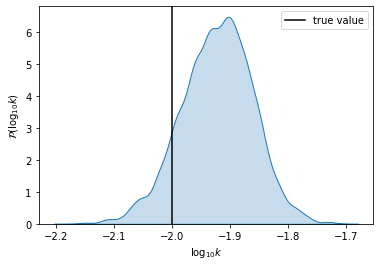

In [8]:
sns.kdeplot(XMCMC[:,0],shade=True) # Plot of the kernel density function that results from the MCMC sampling
plt.xlabel('$\log_{10} k$')
plt.ylabel('$\mathcal{P}(\log_{10} k)$')
plt.axvline(x = -2, color = 'black', label = 'true value')
plt.legend()

This result is ok. We are only using one data point to estimate $k$. You can play with adding more points and/or reducing or enlarging the noise levels. You will see this solution changing.

We now plot the prediction that we can make with such $\mathcal{P}(k)$ estimation by propagating the probability distribution function through the heat diffusion model to get $T(x)$.

In [9]:
n_sols = len(XMCMC)
sol = np.ndarray((n_sols,N))
upper = [0.]*N # 95% condifence interval upper bound
lower = [0.]*N # 95% condifence interval lower bound
mean = [0.]*N

for i in range(n_sols):
    sol[i] = true_model.heat_solve(10**XMCMC[i])
    true_model.bc_setup(T_left,T_right)

for i in range(N):
    mean[i] = np.mean(sol[:,i])
    upper[i] = np.percentile(sol[:,i],97.5)
    lower[i] = np.percentile(sol[:,i],2.5)

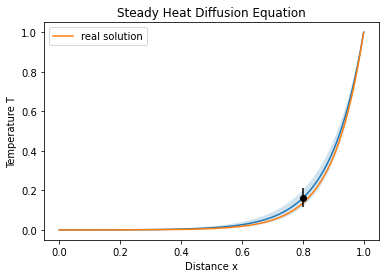

In [10]:
plt.plot(true_model.x,mean)
plt.plot(true_model.x,real_sol,label='real solution')
plt.fill_between(true_model.x,upper,lower,alpha=0.2)
plt.scatter(experimental_data[0][0],experimental_data[0][1],color='black',zorder=4)
plt.errorbar(experimental_data[0][0],experimental_data[0][1],yerr=2*0.15*experimental_data[0][1],color='black')
plt.xlabel('Distance x')
plt.ylabel('Temperature T')
plt.title('Steady Heat Diffusion Equation')
plt.legend()

## Investigating the role of different measurements and likelihoods ##

A more interesting exercise is to now consider the same case but assuming we don't even know the boundary conditions of the experiment, which happens very often in fluid mechanics problems.

The first thing we are going to do is to treat our variables as normalized, everything between 0 and 1, that is, $k$, $T_{\mathrm{right}}$ and $T_{\mathrm{left}}$. We then define a 'denormalization' function to then retrieve what the canonical values represent in physical reality, once we analyze the results.

In [68]:
def denormalization(x,ub,lb):
    """
    Function that de-normalizes a quantity x for given upper and lower bounds.
    Parameters
    ----------
    x : float or 1D array
        Quantity to de-normalize.
    ub : float or 1D array
        Upper bounds of each component of x.
    lb: float
        Lower bounds of each component of x.
    Output
    ----------   
    x_dnorm: float or 1D array
        De-normalized quantity     
    """
    x_dnorm = (x*(ub-lb)) + lb
    return x_dnorm

The likelihood is defined for a uniform prior again, in this case, as all parameters values range between 0 and 1, the if condition is rather easy to impose and easily applies to the thermal diffusivity coefficient as well as the temperature boundary conditions.

In [69]:
## With BC conditions unknown ##
def likelihood(params): # params is the vector of all parameters to be inferred: [k,Tleft,Tright]
    for i in range(len(params)):
        if params[i]<0 or params[i]>1:
            return -1.e16
    heat_model.bc_setup(params[1],params[2]) # The parameters that enter the heat model must be physical so we 'denormalize' them
    L = -(experimental_data[0][1] - heat_model.heat_solve(10**denormalization(params[0],0,-4))[n])**2/(2*sigma[0]**2)
    
    return L 

We now sample from the posterior.

In [70]:
n_params = 3 # [k,Tleft,Tright]
nburn = 10000
sampler = mcmc.metropolis(np.identity(n_params)*0.01,likelihood,nburn)

sampler.seed([0.5]*n_params)

sampler.Burn()
nchain = 10000
XMCMC_bc = np.zeros((nchain,n_params))
for i in range(nchain):
    XMCMC_bc[i] = sampler.DoStep(1)
    heat_model.bc_setup(T_left,T_right)
print("Done")

Burning 10000 samples...
Accept rate 0.1366

Done


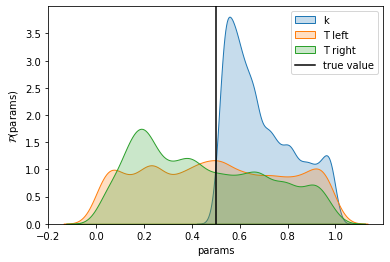

In [71]:
sns.kdeplot(XMCMC_bc[:,0],shade=True,label='k')
sns.kdeplot(XMCMC_bc[:,1],shade=True,label='T left')
sns.kdeplot(XMCMC_bc[:,2],shade=True,label='T right')
plt.xlabel('params')
plt.ylabel('$\mathcal{P}(\mathrm{params})$')
plt.axvline(x = 0.5, color = 'black', label = 'true value')
plt.legend()

The results still contain the true $k$ values but the overall distribution for $k$ is quite deviated. Clearly, not knowing the boundary conditions has a big impact. We can check the predictive posterior again.

In [72]:
## With BC unknown ##
for i in range(n_sols):
    true_model.bc_setup(XMCMC_bc[i,1],XMCMC_bc[i,2])
    sol[i] = true_model.heat_solve(10**denormalization(XMCMC_bc[i,0],0,-4))

for i in range(N):
    mean[i] = np.mean(sol[:,i])
    upper[i] = np.percentile(sol[:,i],97.5)
    lower[i] = np.percentile(sol[:,i],2.5)

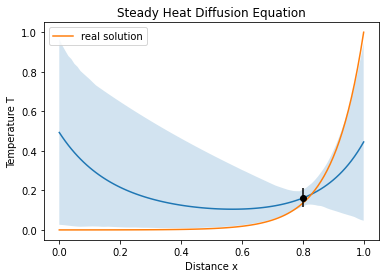

In [73]:
plt.plot(true_model.x,mean)
plt.plot(true_model.x,real_sol,label='real solution')
plt.fill_between(true_model.x,upper,lower,alpha=0.2)
plt.scatter(experimental_data[0][0],experimental_data[0][1],color='black',zorder=4)
plt.errorbar(experimental_data[0][0],experimental_data[0][1],yerr=2*0.15*experimental_data[0][1],color='black')
plt.xlabel('Distance x')
plt.ylabel('Temperature T')
plt.title('Steady Heat Diffusion Equation')
plt.legend()

Interestingly, the prediction is still spot on! Information is inevitably lost on the model parameters without any information about the boundary conditions but the predictive powers are still ok. We could now add some information about the boundary conditions, for instance, we could have one of them measured or the prior range restricted. The following likelihood restricts the value of $T_{\mathrm{left}}$ to be between [0, 0.2] in the canonical space.

In [74]:
def likelihood(params): # params is the vector of all parameters to be inferred: [k,Tleft,Tright]
    for i in range(len(params)):
        if params[i]<0 or params[i]>1:
            return -1.e16
    heat_model.bc_setup(denormalization(params[1],0.2,0.),params[2]) # The parameters that enter the heat model must be physical so we 'denormalize' them
    L = -(experimental_data[0][1] - heat_model.heat_solve(10**denormalization(params[0],0,-4))[n])**2/(2*sigma[0]**2)
    
    return L

In [75]:
n_params = 3 # [k,Tleft,Tright]
nburn = 10000
sampler = mcmc.metropolis(np.identity(n_params)*0.01,likelihood,nburn)

sampler.seed([0.5]*n_params)

sampler.Burn()
nchain = 10000
XMCMC_bc = np.zeros((nchain,n_params))
for i in range(nchain):
    XMCMC_bc[i] = sampler.DoStep(1)
    heat_model.bc_setup(T_left,T_right)
print("Done")

Burning 10000 samples...
Accept rate 0.1267

Done


In [78]:
## With BC unknown ##
for i in range(n_sols):
    true_model.bc_setup(denormalization(XMCMC_bc[i,1],0.2,0.),XMCMC_bc[i,2]) # denormalization(XMCMC_bc[i,1],0.2,0.)
    sol[i] = true_model.heat_solve(10**denormalization(XMCMC_bc[i,0],0,-4))

for i in range(N):
    mean[i] = np.mean(sol[:,i])
    upper[i] = np.percentile(sol[:,i],97.5)
    lower[i] = np.percentile(sol[:,i],2.5)

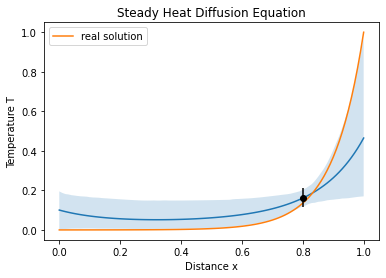

In [79]:
plt.plot(true_model.x,mean)
plt.plot(true_model.x,real_sol,label='real solution')
plt.fill_between(true_model.x,upper,lower,alpha=0.2)
plt.scatter(experimental_data[0][0],experimental_data[0][1],color='black',zorder=4)
plt.errorbar(experimental_data[0][0],experimental_data[0][1],yerr=2*0.15*experimental_data[0][1],color='black')
plt.xlabel('Distance x')
plt.ylabel('Temperature T')
plt.title('Steady Heat Diffusion Equation')
plt.legend()

Now, we also assume that $T_{\mathrm{right}}$ is measured with a certain noise level so we have to add it to the likelihood.

In [80]:
sigma = [0.15*true_model.return_T_in_x_position(n),0.15]
experimental_data = [[x,true_model.return_T_in_x_position(n)+np.random.normal(loc=0,scale=sigma[0])],[1,1+np.random.normal(loc=0,scale=sigma[1])]]

## With BC conditions unknown ##
def likelihood(params): # params is the vector of all parameters to be inferred: [k,Tright,Tleft]
    for i in range(len(params)):
        if params[i]<0 or params[i]>1:
            return -1.e16
    heat_model.bc_setup(params[1],params[2]) # The parameters that enter the heat model must be physical so we 'denormalize' them
    L = -(experimental_data[0][1] - heat_model.heat_solve(10**denormalization(params[0],0,-4))[n])**2/(2*sigma[0]**2)-(experimental_data[1][1] - params[2])**2/(2*sigma[1]**2)
    
    return L

In [81]:
n_params = 3 # [k,Tright,Tleft]
nburn = 10000
sampler = mcmc.metropolis(np.identity(n_params)*0.01,likelihood,nburn)

sampler.seed([0.5]*n_params)

sampler.Burn()
nchain = 10000
XMCMC_bc = np.zeros((nchain,n_params))
for i in range(nchain):
    XMCMC_bc[i] = sampler.DoStep(1)
    heat_model.bc_setup(T_left,T_right)
print("Done")

Burning 10000 samples...
Accept rate 0.2475

Done


In [82]:
## With BC unknown ##
for i in range(n_sols):
    true_model.bc_setup(denormalization(XMCMC_bc[i,1],0.2,0.),XMCMC_bc[i,2]) # denormalization(XMCMC_bc[i,1],0.2,0.)
    sol[i] = true_model.heat_solve(10**denormalization(XMCMC_bc[i,0],0,-4))

for i in range(N):
    mean[i] = np.mean(sol[:,i])
    upper[i] = np.percentile(sol[:,i],97.5)
    lower[i] = np.percentile(sol[:,i],2.5)

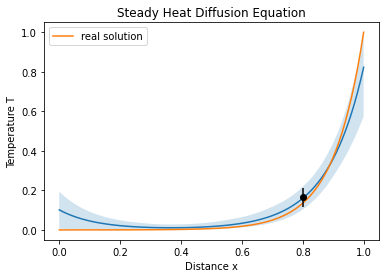

In [83]:
plt.plot(true_model.x,mean)
plt.plot(true_model.x,real_sol,label='real solution')
plt.fill_between(true_model.x,upper,lower,alpha=0.2)
plt.scatter(experimental_data[0][0],experimental_data[0][1],color='black',zorder=4)
plt.errorbar(experimental_data[0][0],experimental_data[0][1],yerr=2*0.15*experimental_data[0][1],color='black')
plt.xlabel('Distance x')
plt.ylabel('Temperature T')
plt.title('Steady Heat Diffusion Equation')
plt.legend()

## Investigating the role of priors ##

We now investigate the role of priors. Instead of assuming a boring flat distribution, we are going to impose a Gaussian distribution for the case where we only infer the thermal diffusivity coefficient $k$.

In [84]:
## Defining a different prior ##
def prior(k):
    P = -(0.1 - 10**k[0])**2/(2*0.01**2) ## Gaussian prior centered on 0.1 and std. dev 0.01
    return P

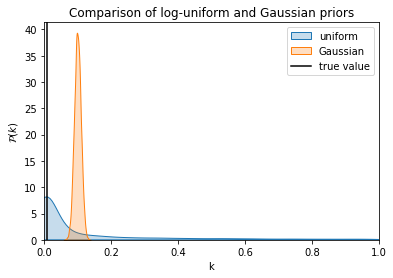

In [85]:
prior_uniform = np.random.uniform(-4,0,10000)
prior_gaussian = np.random.normal(loc=0.1,scale=0.01,size=10000)
sns.kdeplot(10**prior_uniform,shade=True,label='uniform')
sns.kdeplot(prior_gaussian,shade=True,label='Gaussian')
plt.axvline(x = 0.01, color = 'black', label = 'true value')
plt.title('Comparison of log-uniform and Gaussian priors')
plt.xlabel('k')
plt.ylabel('$\mathcal{P}(k)$')
plt.xlim(0,1)
plt.legend()

In [86]:
def likelihood(k):
    L = -(experimental_data[0][1] - heat_model.heat_solve(10**k[0])[n])**2/(2*sigma[0]**2)
    heat_model.bc_setup(T_left,T_right)
    return L

The likelihood does not have the prior 'built-in' so we need to define the log-posterior for sampling. As we are working in the log-space, the multiplication between likelihood and prior becomes an addition instead for the log-posterior.

In [87]:
## Defining the posterior ##
def posterior(k):
    post = likelihood(k)+prior(k) # Multiplication is sum in the log scale
    return post

In [88]:
n_params = 1
nburn = 10000
sampler = mcmc.metropolis(np.identity(n_params)*0.01,posterior,nburn) # We sample the posterior

sampler.seed([-3]*n_params)

sampler.Burn()
nchain = 10000
XMCMC_prior = np.zeros((nchain,n_params))
for i in range(nchain):
    XMCMC_prior[i] = sampler.DoStep(1)
    heat_model.bc_setup(T_left,T_right)
print("Done")

Burning 10000 samples...
Accept rate 0.3875

Done


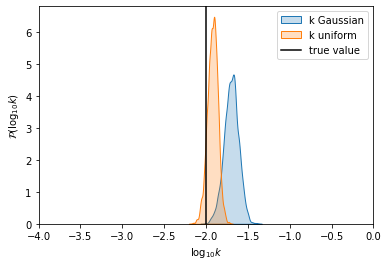

In [89]:
sns.kdeplot(XMCMC_prior[:,0],shade=True,label='k Gaussian')
sns.kdeplot(XMCMC[:,0],shade=True,label='k uniform')
plt.xlim(-4,0)
plt.axvline(x = -2, color = 'black', label = 'true value')
plt.xlabel('$\log_{10} k$')
plt.ylabel('$\mathcal{P}(\log_{10}  k)$')
plt.legend()

In this case, the Gaussian prior completely misses the truth as it is biased towards larger values of $k$. Still, the experimental data does a good job in moving the posterior towards the truth but it is not enough (check distance of prior to true value versus posterior to true value, you'll notice the displacement caused by the data). We can also check the prediction produced.

In [90]:
for i in range(n_sols):
    sol[i] = true_model.heat_solve(10**XMCMC_prior[i])
    true_model.bc_setup(T_left,T_right)

for i in range(N):
    mean[i] = np.mean(sol[:,i])
    upper[i] = np.percentile(sol[:,i],97.5)
    lower[i] = np.percentile(sol[:,i],2.5)

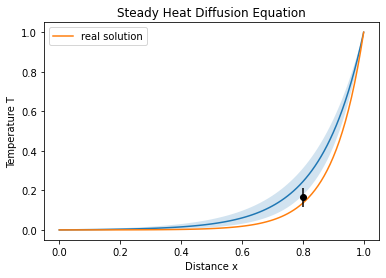

In [91]:
plt.plot(true_model.x,mean)
plt.plot(true_model.x,real_sol,label='real solution')
plt.fill_between(true_model.x,upper,lower,alpha=0.2)
plt.scatter(experimental_data[0][0],experimental_data[0][1],color='black',zorder=4)
plt.errorbar(experimental_data[0][0],experimental_data[0][1],yerr=2*0.15*experimental_data[0][1],color='black')
plt.xlabel('Distance x')
plt.ylabel('Temperature T')
plt.title('Steady Heat Diffusion Equation')
plt.legend()

Indeed, we observe how the prediction overestimates the temperature given the overestimation of the thermal diffusivity coefficient $k$ produced by the biased prior. Always check your priors!!

## DRAM: Delayed Rejection Adaptive Metropolis MCMC algorithm ##

This MCMC algorithm comes to fix the problems with the classical Metropolis-Hastings algorithm. The classical MH algorithm adapts the covariance matrix after a series of burn-in steps. This is more effective if a good amount of proposal moves are accepted, otherwise no real information is obtained by the chain as to how much the proposal should adapt to the posterior. To fix this problem, Haario et al (2006) proposed the delayed rejection concept. In this case, if a proposal move is rejected initially, we don't count the same point as an additional point of our Markov chain but we shrink the proposal and propose a new move. We can do this several times as prescribed by ourselves. The rejected samples can also be used to inform the adaptation of the covariance matrix on-the-fly. In practice, the DRAM algorithm looks like the following.

In [92]:
def drmcmc(logp, x0, var, nsteps, nreject=100, gamma=0.1, alpha=0.24):
    """
    Delayed rejection adaptive Metropolis (DRAM) MCMC algorithm.
    
    Parameters:
    -----------
    logp : function
        The log of the posterior probability density function to be sampled.
    x0 : numpy.ndarray
        The initial state of the Markov chain.
    var : numpy.ndarray
        The initial proposal covariance matrix.
    nsteps : int
        The number of MCMC steps to run.
    nreject : int, optional
        The maximum number of rejections to allow before adjusting the proposal.
    gamma : float, optional
        The shrinkage factor used to adjust the proposal covariance matrix.
    alpha : float, optional
        The target acceptance rate used to adjust the proposal covariance matrix.
    
    Returns:
    --------
    chain : numpy.ndarray
        The Markov chain of samples.
    accrate : float
        The acceptance rate of the final proposal.
    """
    
    ndim = len(x0)
    chain = np.zeros((nsteps, ndim))
    chain[0] = x0
    accrate = 0.0
    accept_count = 0
    
    for i in range(1, nsteps):
        # Generate a new proposal
        z = np.random.multivariate_normal(np.zeros(ndim), var)
        y = chain[i-1] + z
        
        # Compute the acceptance probability
        lp_y = logp(y)
        lp_x = logp(chain[i-1])
        q_yx = multivariate_normal.pdf(chain[i-1], y, var)
        q_xy = multivariate_normal.pdf(y, chain[i-1], var)
        alpha1 = np.exp(lp_y - lp_x + np.log(q_xy) - np.log(q_yx))
        
        if np.random.rand() < alpha1:
            # Accept the proposal
            chain[i] = y
            accept_count += 1
            accrate = accept_count / i
        else:
            # Delayed rejection
            for j in range(3):
                # Generate a new proposal
                zj = np.random.multivariate_normal(np.zeros(ndim), gamma**j * var)
                yj = chain[i-1] + zj
                
                # Compute the acceptance probability
                lp_yj = logp(yj)
                q_yxj = multivariate_normal.pdf(chain[i-1], yj, gamma**j * var)
                q_xyj = multivariate_normal.pdf(yj, chain[i-1], gamma**j * var)
                alpha_j = np.exp(lp_yj - lp_x + np.log(q_xyj) - np.log(q_yxj))
                
                if np.random.rand() < alpha_j:
                    # Accept the proposal
                    chain[i] = yj
                    accept_count += 1
                    accrate = accept_count / i
                    break
            else:
                # All proposals rejected
                chain[i] = chain[i-1]
    
        # Adjust the proposal covariance matrix
        if i % nreject == 0:
            cov = np.cov(chain[:i+1], rowvar=False)
            cov = alpha * var + (1 - alpha) * cov
            var = gamma * cov
    
    return chain, accrate

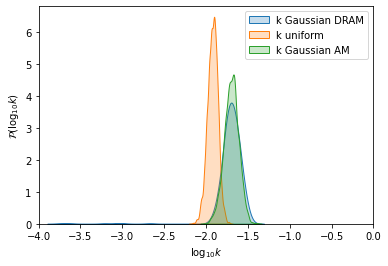

In [95]:
# Run the MCMC algorithm
x0 = np.array([-3])
var = np.eye(1)
nsteps = 500
chain, accrate = drmcmc(posterior, x0, var, nsteps)

sns.kdeplot(chain[:,0],shade=True,label='k Gaussian DRAM')
sns.kdeplot(XMCMC[:,0],shade=True,label='k uniform')
sns.kdeplot(XMCMC_prior[:,0],shade=True,label='k Gaussian AM')
plt.xlabel('$\log_{10} k$')
plt.ylabel('$\mathcal{P}(\log_{10} k)$')
plt.xlim(-4,0)
plt.legend()

We can see that the DRAM algorithm needs less samples to converge to the same posterior distribution than the classical MH. You can play with the number of samples for both and see the relative differences. To make sure that both chains can be compared (a.k.a. well-converged), we can compute the autocorrelation functions.

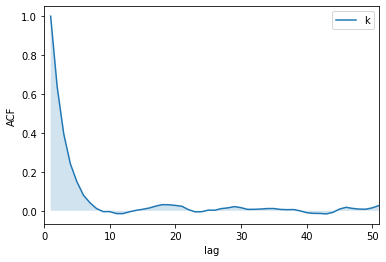

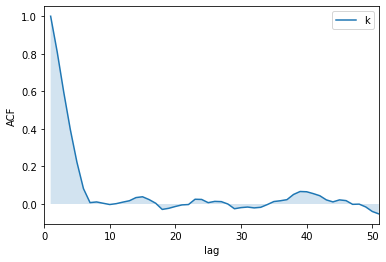

In [96]:
dict_var = {0: 'k'}
diag_MH = mcmc.diagnostics(XMCMC_prior[:,0],dict_var)
diag_DRAM = mcmc.diagnostics(chain[:,0],dict_var)

diag_MH.autocorr1d(50)
diag_DRAM.autocorr1d(50)